# Reducción de Ruido en Audio de Disparo
Este notebook aplica distintas técnicas de reducción de ruido sobre un audio de disparo de 4 segundos. Se grafican los resultados en dominio del tiempo y frecuencia, y se permite la escucha de los audios procesados.

c:\Users\HudayPlata\Documents\Unimag Tesis\Code\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Duración del audio: 5.76 segundos


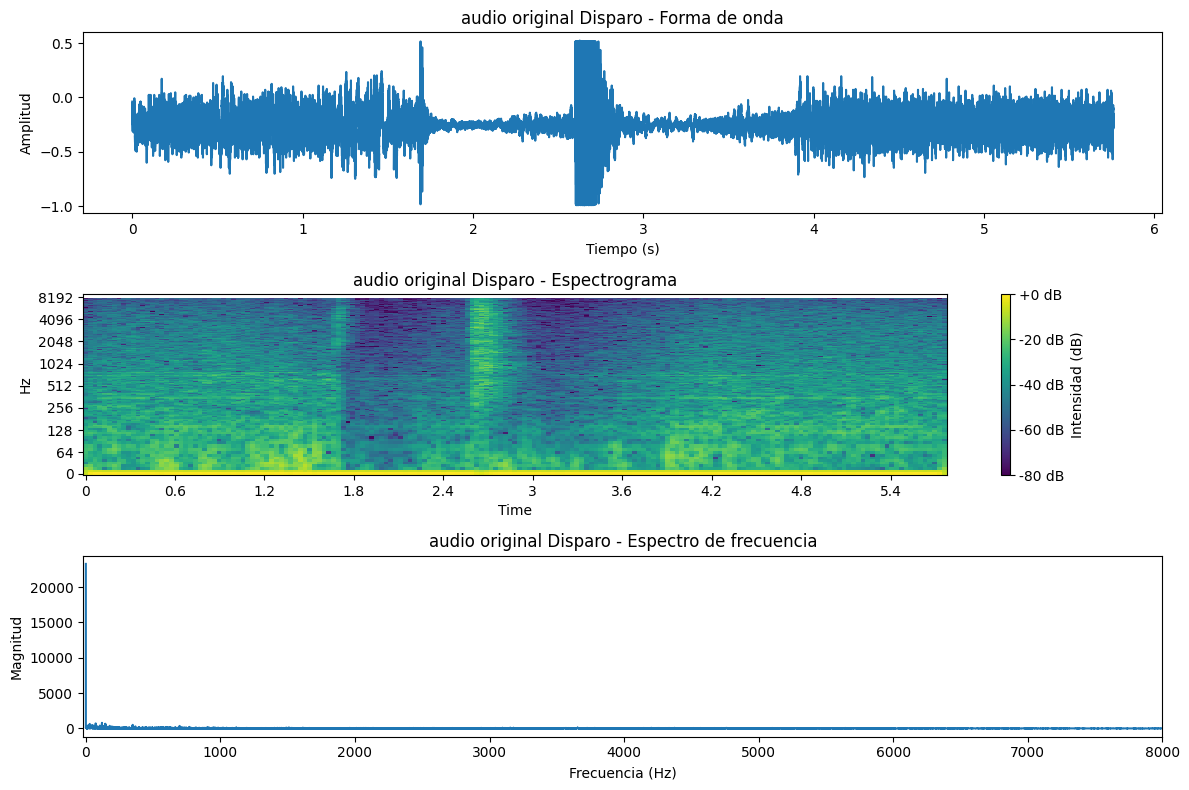

In [1]:
import pywt
import pywt.data
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import scipy.signal as signal
import noisereduce as nr

def visualizar_audio(señal, sr, titulo="Audio"):
    """Visualiza la señal de audio en dominio del tiempo y frecuencia"""
    plt.figure(figsize=(12, 8))  # Aumenté ligeramente el tamaño vertical
    
    # Forma de onda
    plt.subplot(3, 1, 1)
    plt.title(f"{titulo} - Forma de onda")
    tiempo = np.linspace(0, len(señal)/sr, len(señal))
    plt.plot(tiempo, señal)
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    
    # Espectrograma (ajustado hasta 8000 Hz)
    plt.subplot(3, 1, 2)
    plt.title(f"{titulo} - Espectrograma")
    D = librosa.amplitude_to_db(np.abs(librosa.stft(señal)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap='viridis')
    plt.ylim(top=9000)  # Límite máximo en eje Y
    plt.colorbar(format='%+2.0f dB', label='Intensidad (dB)')  # Etiqueta añadida
    
    # FFT (ajustado hasta 8000 Hz)
    plt.subplot(3, 1, 3)
    plt.title(f"{titulo} - Espectro de frecuencia")
    X = np.fft.fft(señal)
    X_mag = np.abs(X)[:len(X)//2]
    f = np.linspace(0, sr/2, len(X_mag))
    plt.plot(f, X_mag)
    plt.xlim(-20, 8000)  # Límite máximo en eje X
    plt.xlabel("Frecuencia (Hz)")
    plt.ylabel("Magnitud")
    
    plt.tight_layout()
    plt.show()


# Cargar el audio (reemplazar por tu archivo)
AUDIO_PATH = "C:/Users/HudayPlata/Documents/Unimag Tesis/Audio Tesis"
audio_path = f"{AUDIO_PATH}/Audio_Datasets/PoligonoTiro/Audio_Poligono_4.wav"  # Cambia esto por tu archivo de disparo
audio_path_noise = f"{AUDIO_PATH}/Audio_Datasets/PoligonoNoTiro/Audio_Poligono_6.wav"
# Reemplaza con la ruta de tu archivo
y, sr = librosa.load(audio_path, sr=None)
y_noise, sr_noise = librosa.load(audio_path_noise, sr=None)
dur = librosa.get_duration(y=y, sr=sr)
print(f'Duración del audio: {dur:.2f} segundos')

# Reproducir el audio original
visualizar_audio(y, sr, "audio original Disparo")
ipd.Audio(y, rate=sr)

## 2. Filtro Paso Banda (Eliminación de bajas y altas frecuencias)

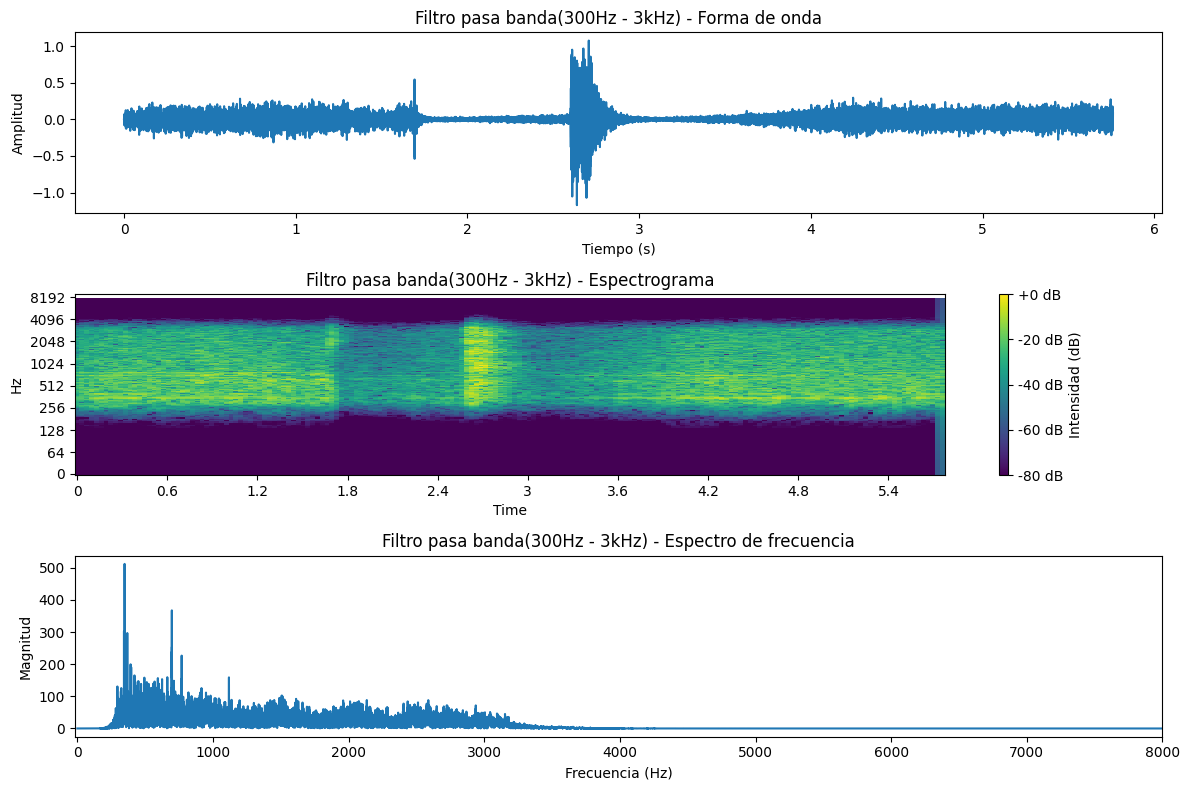

In [2]:
# Aplicar filtro paso banda entre 300Hz y 3000Hz
sos = signal.butter(10, [300, 3000], btype='bandpass', fs=sr, output='sos')
y_filtered = signal.sosfilt(sos, y)

visualizar_audio(y_filtered, sr, "Filtro pasa banda(300Hz - 3kHz)")
ipd.Audio(y_filtered, rate=sr)

## 1. Reducción de Ruido con Sustracción Espectral (Noisereduce)

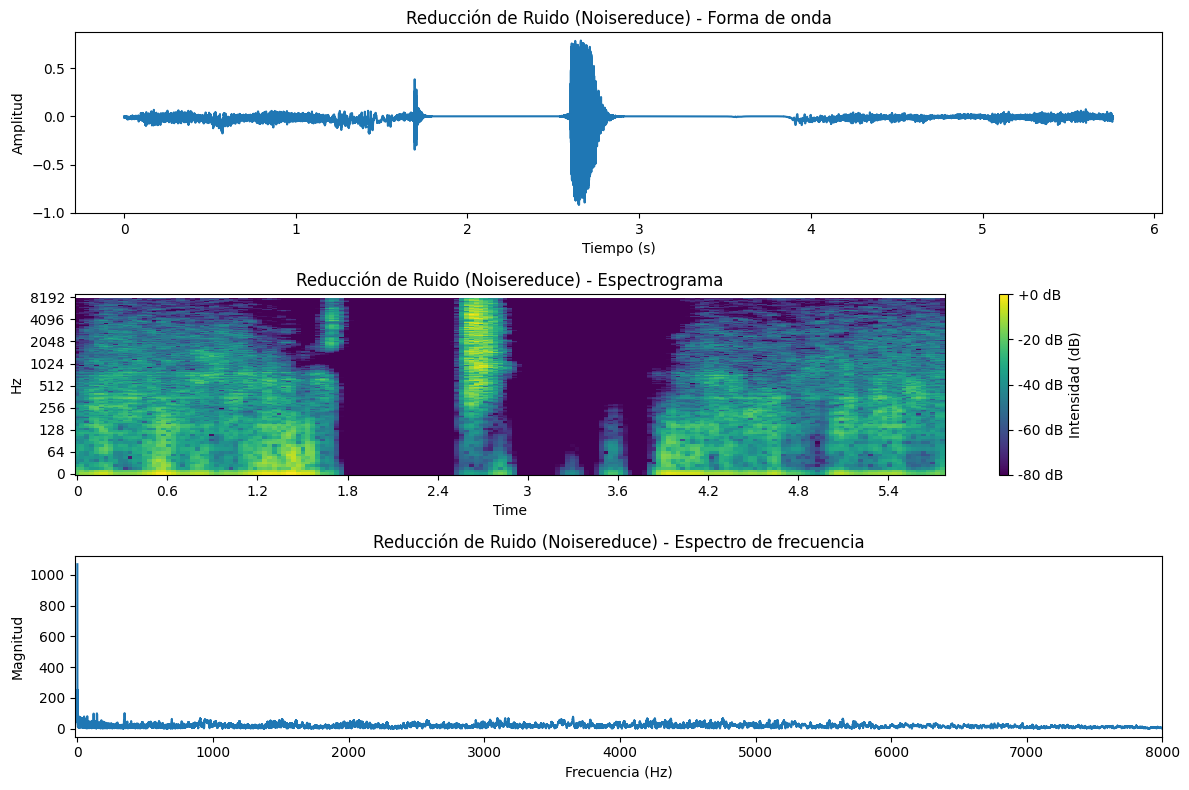

In [3]:
# Asumimos que el ruido está presente en los primeros 0.5 segundos
noise_sample = y_noise
y_nr = nr.reduce_noise(y=y, sr=sr, y_noise=noise_sample, use_tqdm=True, clip_noise_stationary=False)

visualizar_audio(y_nr, sr, "Reducción de Ruido (Noisereduce)")
ipd.Audio(y_nr, rate=sr)


92160
64000


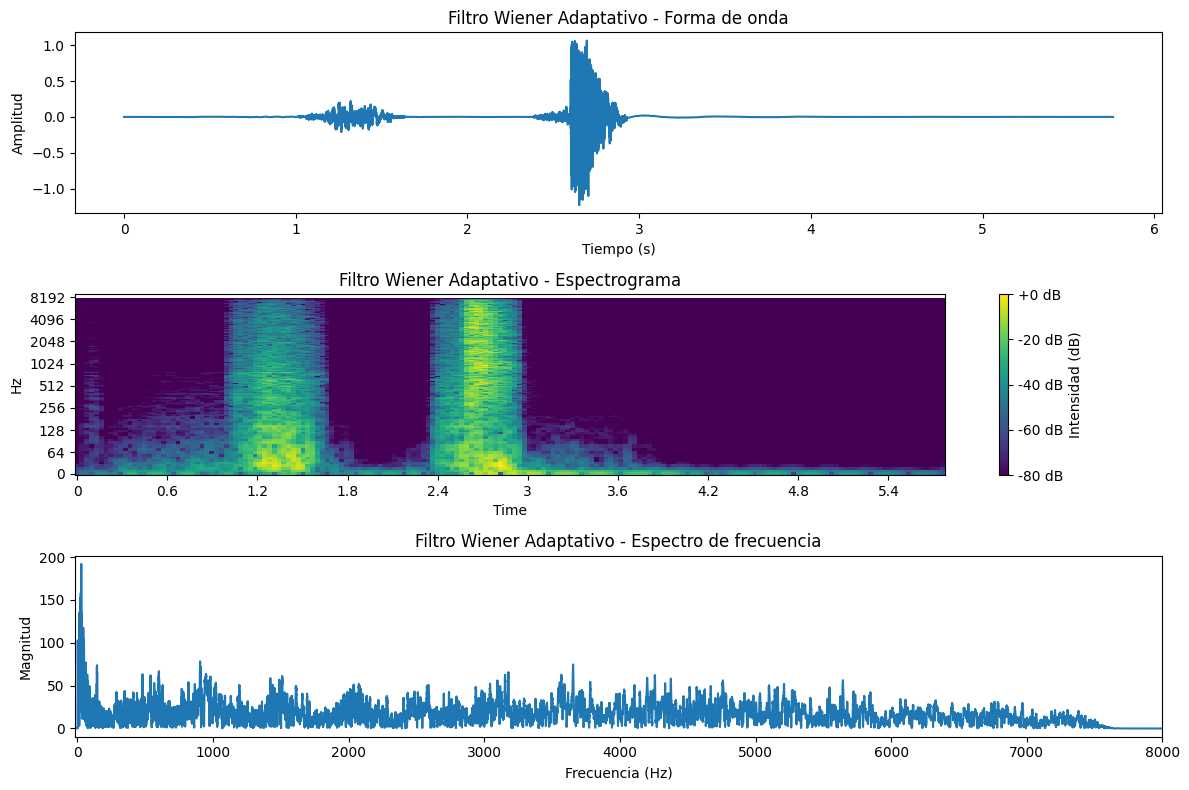

In [4]:
def filter_weiner(y,sr):
    """
    Aplica filtro de Wiener adaptativo por segmentos para eliminar ruido no estático

    Parámetros:
    - señal: array de NumPy con los datos de audio
    - longitud_ventana: tamaño de la ventana para análisis local
    - solapamiento: cantidad de muestras solapadas entre ventanas

    Retorna:
    - señal filtrada con ruido reducido
    """
    print(len(y))
    print(int(4*sr))
    longitud_ventana=int(2*sr)
    solapamiento=int(longitud_ventana/50)
    señal_procesada = np.zeros_like(y)
    paso = longitud_ventana - solapamiento

    # Procesar por ventanas
    for i in range(0, len(y) - longitud_ventana + 1, paso):
        segmento = y[i:i+longitud_ventana]
        # Aplicar filtro de Wiener al segmento
        segmento_limpio = signal.wiener(segmento, mysize=8000)
        
        # Aplicar ventana Hanning para suavizar transiciones
        ventana = np.hanning(longitud_ventana)
        segmento_limpio = segmento_limpio * ventana
        
        # Método de superposición y suma (overlap-add)
        señal_procesada[i:i+longitud_ventana] += segmento_limpio

    # Normalizar resultado final
    y_wiener = señal_procesada/ np.max(np.abs(señal_procesada))

    sos = signal.butter(10, [2, 7500], btype='bandpass', fs=sr, output='sos')
    y_wiener_filtered = signal.sosfilt(sos, y_wiener)
    return y_wiener_filtered

y_wiener_filtered = filter_weiner(y,sr)
visualizar_audio(y_wiener_filtered, sr, "Filtro Wiener Adaptativo")
ipd.Audio(y_wiener_filtered, rate=sr)

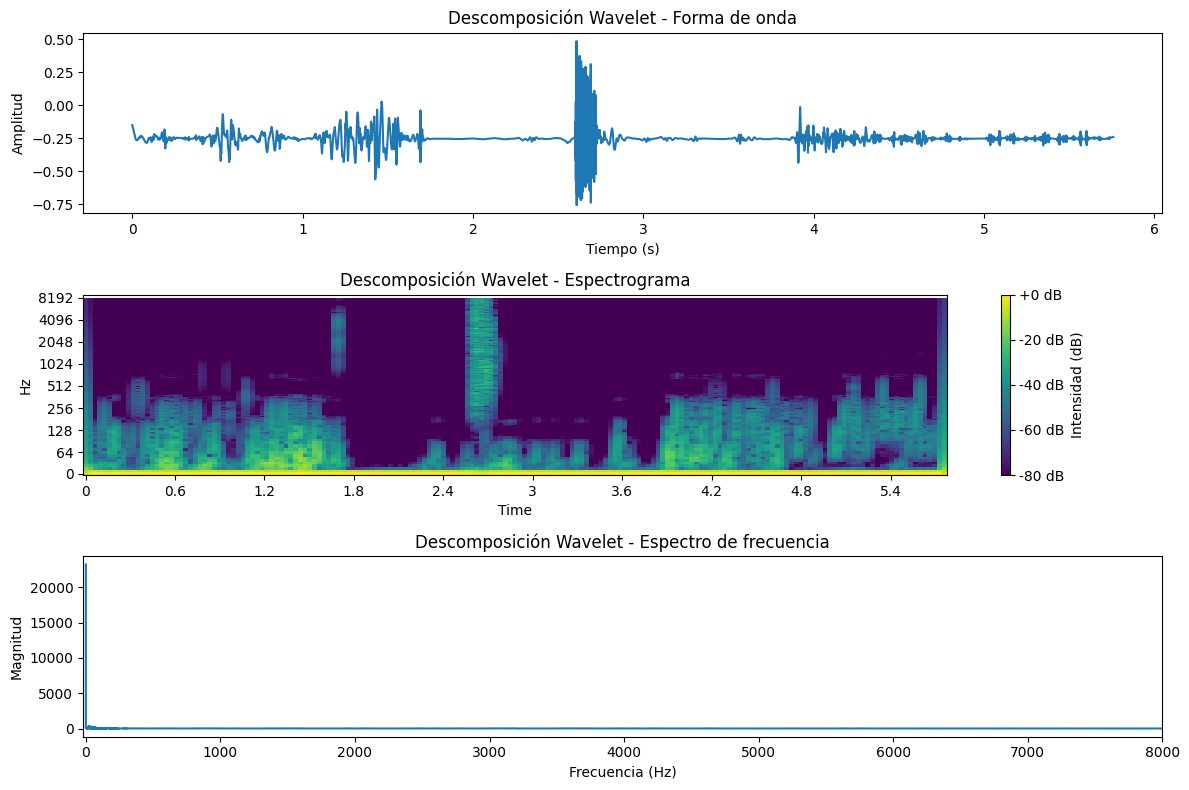

In [8]:
# 2. DESCOMPOSICIÓN WAVELET PARA ELIMINACIÓN DE RUIDO
def eliminar_ruido_wavelet(señal, wavelet='db8', nivel=10, umbral_factor=2.5):
    """
    Elimina ruido usando descomposición wavelet con umbralización
    
    Parámetros:
    - señal: array de NumPy con los datos de audio
    - wavelet: tipo de wavelet (db8, sym8, coif5, etc.)
    - nivel: nivel de descomposición
    - umbral_factor: factor para calcular el umbral de supresión de ruido
    
    Retorna:
    - señal con ruido reducido
    """
    # Realizar la descomposición wavelet multi-nivel
    coeficientes = pywt.wavedec(señal, wavelet, level=nivel)
    
    # Calcular umbral adaptativo basado en la estimación del ruido
    sigma = (np.median(np.abs(coeficientes[-1])) / 0.86745)
    umbral = umbral_factor * sigma * np.sqrt(2 * np.log(len(señal)))
    
    # Aplicar umbralización suave (soft thresholding) a los coeficientes de detalle
    coefs_nuevos = [coeficientes[0]]  # Mantener coeficientes de aproximación
    
    for i in range(1, len(coeficientes)):
        # Umbralización suave
        coefs_nuevos.append(pywt.threshold(coeficientes[i], umbral, mode='soft'))
    
    # Reconstruir la señal con los coeficientes modificados
    señal_limpia = pywt.waverec(coefs_nuevos, wavelet)
    
    # Asegurar que la longitud de la señal reconstruida sea igual a la original
    señal_limpia = señal_limpia[:len(señal)]
    
    return señal_limpia
# 2. Descomposición Wavelet
señal_wavelet = eliminar_ruido_wavelet(y, wavelet='db8', nivel=10, umbral_factor=8)
visualizar_audio(señal_wavelet, sr, "Descomposición Wavelet")
ipd.Audio(señal_wavelet, rate=sr)

92160
64000


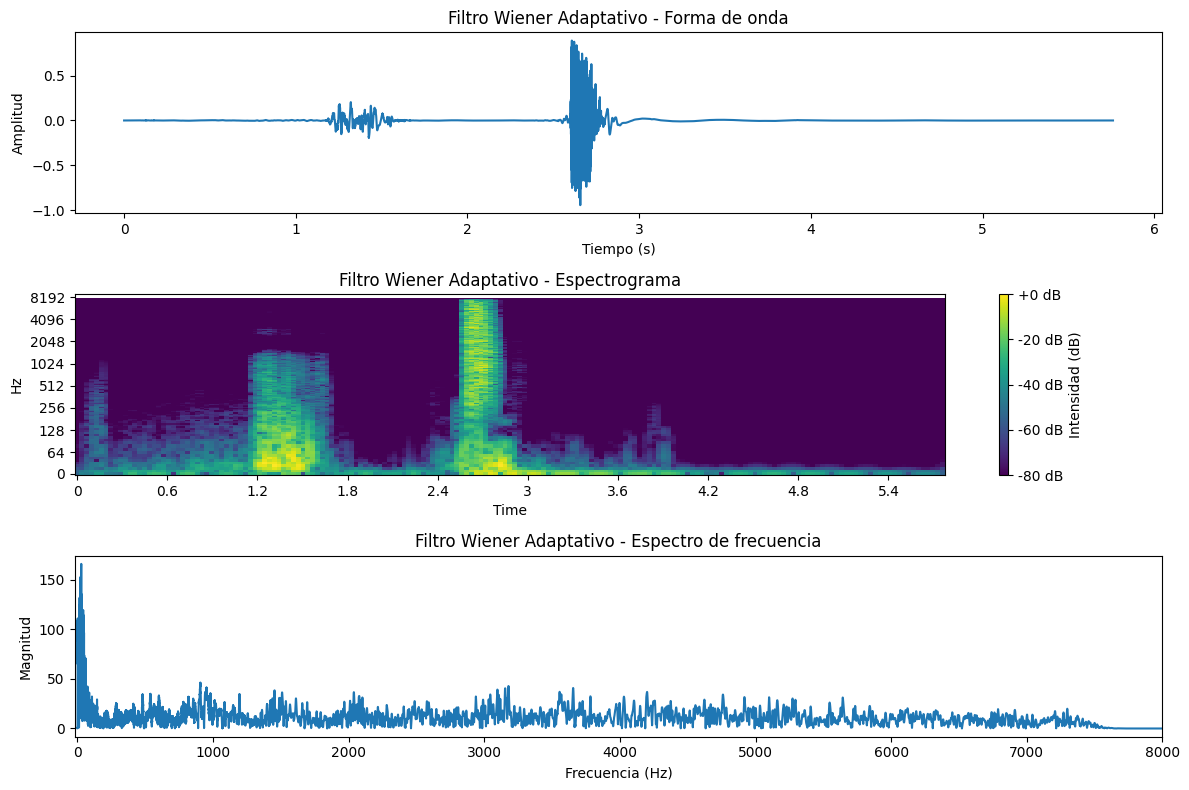

In [6]:
y_wiener_filtered = filter_weiner(señal_wavelet,sr)
visualizar_audio(y_wiener_filtered, sr, "Filtro Wiener Adaptativo")
ipd.Audio(y_wiener_filtered, rate=sr)